In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import polars as pl
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:

drive.mount('/content/drive')
honda = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Honda_Data.csv")
google = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Google 2020-2025 Stock Market.csv")
intel = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/intel_data.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


скачиваем датасет с гита

In [ ]:
!wget https://huggingface.co/datasets/Zihan1004/FNSPID/resolve/main/Stock_news/nasdaq_exteral_data.csv

--2025-05-26 09:54:25--  https://huggingface.co/datasets/Zihan1004/FNSPID/resolve/main/Stock_news/nasdaq_exteral_data.csv
Resolving huggingface.co (huggingface.co)... 3.166.152.110, 3.166.152.44, 3.166.152.105, ...
Connecting to huggingface.co (huggingface.co)|3.166.152.110|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/a0/19/a01967ba742831f4b6903f146b4f5d9a3d2eeeefa619387e8cc87df2d889332c/1a7a3eb8e6b97ec19f286f2cfca3371542bddb272ab1eb8f36e33ad98fa5c4da?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27nasdaq_exteral_data.csv%3B+filename%3D%22nasdaq_exteral_data.csv%22%3B&response-content-type=text%2Fcsv&Expires=1748256865&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0ODI1Njg2NX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2EwLzE5L2EwMTk2N2JhNzQyODMxZjRiNjkwM2YxNDZiNGY1ZDlhM2QyZWVlZWZhNjE5Mzg3ZThjYzg3ZGYyZDg4OTMzMmMvMWE3YTNlYjhlNmI5N2VjMTlmMjg2ZjJjZ

In [ ]:
!pip install polars


оставили только гугл хонду и интел

In [ ]:
path = "nasdaq_exteral_data.csv"

df = pl.scan_csv(path)

tickers = ["GOOGL", "INTC", "HMC"]

filtered = df.filter(pl.col("Stock_symbol").is_in(tickers))

filtered = filtered.select(["Stock_symbol", "Article_title", "Date"])

filtered.collect().write_csv("filtered_news.csv")

In [ ]:
filtered.collect().write_csv("filtered_news.csv")


In [ ]:

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp filtered_news.csv "/content/drive/MyDrive/Colab Notebooks/filtered_news.csv"


In [ ]:
!ls


drive		   nasdaq_exteral_data.csv    sample_data
filtered_news.csv  nasdaq_exteral_data.csv.1


In [ ]:

F_news= pd.read_csv("/content/drive/MyDrive/Colab Notebooks/filtered_news.csv")
F_news

,Stock_symbol,Article_title,Date,sentiment_score
0,INTC,3 Overvalued Stocks That Could Plunge if the M...,2023-12-16 10:00:00 UTC,-1
1,INTC,"IWD, MRK, BAC, INTC: ETF Inflow Alert",2023-12-16 09:00:00 UTC,0
2,INTC,"Company News for Dec 20, 2023",2023-12-16 04:00:00 UTC,0
3,INTC,"Nvidia Stock Dominated 2023, but Investors Sho...",2023-12-16 04:00:00 UTC,0
4,INTC,5 Top Stocks I'm Betting on in 2024,2023-12-16 04:00:00 UTC,0
...,...,...,...,...
15226,INTC,Intel Q3: What to watch,2018-10-25 00:00:00 UTC,0
15227,INTC,Why October Spells Doom for Semis: ETFs in Focus,2018-10-25 00:00:00 UTC,0
15228,INTC,The Signal Event - Will The Dam Hold?,2018-10-25 00:00:00 UTC,0
15229,INTC,"Analysts adjust AMD targets, comment on that r...",2018-10-25 00:00:00 UTC,0


In [ ]:
!pip install sentence-transformers




### Использование модели BERT для анализа новостей

Для анализа текстовой информации в проекте применяется модель BERT (Bidirectional Encoder Representations from Transformers). BERT представляет собой трансформерную архитектуру, разработанную Google, основное преимущество которой — двунаправленное внимание: модель одновременно учитывает как левый, так и правый контексты слова, что обеспечивает глубокое понимание смысловой структуры текста.

В рамках исследования используется специализированная версия модели — FinBERT, предобученная на финансовых текстах. Это позволяет более точно анализировать эмоциональную окраску новостей, касающихся фондового рынка. На выходе модель возвращает категориальную метку (`POSITIVE`, `NEGATIVE`, `NEUTRAL`), отражающую тональность текста, а также вероятность, с которой она уверена в прогнозе.

Данный подход позволяет количественно оценивать влияние информационного потока на фондовые активы: на основе тональности новостей можно строить временные ряды и анализировать их связь с динамикой цен.


добавляем столбец в filltered csv с оценкой bert

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from tqdm import tqdm

# 1. Инициализация FinBERT
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
finbert = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# 2. Применение к F_news
batch_size = 32
texts = F_news['Article_title'].astype(str).tolist()
sentiment_map = {'POSITIVE': 1, 'NEUTRAL': 0, 'NEGATIVE': -1}
scores = []

for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i + batch_size]
    results = finbert(batch)
    scores.extend([sentiment_map[r['label'].upper()] for r in results])

# 3. Добавляем столбец
F_news['sentiment_score'] = scores

# 4. Сохраняем обратно
F_news.to_csv("/content/drive/MyDrive/Colab Notebooks/filtered_news.csv", index=False)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Device set to use cpu
  0%|          | 0/476 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

100%|██████████| 476/476 [36:28<00:00,  4.60s/it]


это мы создаем Относительное изменение:

impact_score
=
∣
Close
𝑡
+
1
−
Close
𝑡
∣
Close
𝑡
impact_score=
Close
t
​

∣Close
t+1
​
 −Close
t
​
 ∣
​



In [ ]:
import pandas as pd

# Список тикеров и соответствующих таблиц с ценами
tickers = [
    ('GOOGL', google),
    ('INTC', intel),
    ('HMC', honda)
]

all_data = []

for ticker, price_df in tickers:
    # 1. Фильтрация новостей по тикеру
    news = F_news[F_news['Stock_symbol'] == ticker].copy()

    # 2. Преобразование даты и удаление временной зоны
    news['Date'] = pd.to_datetime(news['Date'], utc=True).dt.tz_localize(None)
    price_df['Date'] = pd.to_datetime(price_df['Date'], utc=True).dt.tz_localize(None)

    # 3. Объединение новостей и цен по дате
    df = pd.merge(news, price_df[['Date', 'Close']], on='Date', how='inner')

    # 4. Расчёт impact_score — относительное изменение цены на следующий день
    df['Close_next'] = df['Close'].shift(-1)
    df['impact_score'] = abs(df['Close_next'] - df['Close']) / df['Close']

    # 5. Удаление NaN и сохранение нужных колонок
    df = df.dropna(subset=['impact_score'])
    all_data.append(df[['Article_title', 'impact_score']])

# 6. Объединение всех тикеров в один датафрейм
df_all = pd.concat(all_data).reset_index(drop=True)

# 7. (Опционально) Ограничим объём до 1000 строк для ускорения обучения
df_all = df_all.sample(1000, random_state=42) if len(df_all) > 1000 else df_all

# 8. Проверка
print(df_all.head())


<ipython-input-6-d47637f7482d>:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  price_df['Date'] = pd.to_datetime(price_df['Date'], utc=True).dt.tz_localize(None)


                                          Article_title  impact_score
507   FANG Stocks Update: The Whole Lot is Losing Ou...      0.000000
2268  WSJ: Honda to halt Accord production for 11 da...      0.002668
2349  Zacks Industry Outlook Highlights: Tesla, Gene...      0.000000
1788  Ford Suspends Production at IMG Sites on Coron...      0.086477
949   Which Super Bowl LI Commercials Were Social Hits?      0.006155


In [ ]:
all_data

[                                         Article_title  impact_score
 0    MoneyGram Shares Jump 50% As Western Union Rep...      0.005142
 1    The First Week of June Is All About the May's ...      0.000000
 2    The 'Real' S&P 500 And Why The Current Rally M...      0.000000
 3    UK Supply Chain Startup Beacon Raises $15M Fro...      0.001956
 4    'DOJ has interviewed multiple Google competito...      0.000000
 ..                                                 ...           ...
 640  Post-Earning, Which Is Better: Alphabet or Fac...      0.000000
 641  Pachira Investments Inc. Buys Amazon.com Inc, ...      0.000000
 642  Fundamentun, LLC Buys WisdomTree U.S. Dividend...      0.000000
 643  The Zacks Analyst Blog Highlights: Microsoft, ...      0.000000
 644  Zacks Investment Ideas feature highlights: Goo...      0.000000
 
 [645 rows x 2 columns],
 Empty DataFrame
 Columns: [Article_title, impact_score]
 Index: [],
                                           Article_title  impact

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/df_all_impact.csv"
df_all.to_csv(save_path, index=False)
print(f"✅ df_all сохранён → {save_path}")


✅ df_all сохранён → /content/drive/MyDrive/Colab Notebooks/df_all_impact.csv


ПРИЗЫВ DF ALL

самая первая модель

In [ ]:
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load tokenizer and model
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert = AutoModel.from_pretrained(model_name)

# Dataset class
class NewsDataset(Dataset):
    def __init__(self, texts, targets):
        self.texts = texts
        self.targets = targets

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded = tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=128,
            return_tensors="pt"
        )
        return {
            'input_ids': encoded['input_ids'].squeeze(),
            'attention_mask': encoded['attention_mask'].squeeze(),
            'target': torch.tensor(self.targets[idx], dtype=torch.float32)
        }

# Train/test split
X_train, X_val, y_train, y_val = train_test_split(
    df_all['Article_title'].tolist(),
    df_all['impact_score'].tolist(),
    test_size=0.2,
    random_state=42
)

train_dataset = NewsDataset(X_train, y_train)
val_dataset = NewsDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)

# FinBERT with regression head
class FinBERTRegressor(nn.Module):
    def __init__(self, bert):
        super().__init__()
        self.bert = bert
        self.regressor = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0]
        return self.regressor(cls_output).squeeze()

# Initialize model
model = FinBERTRegressor(bert).to(device)

# UNFREEZE BERT
for param in model.bert.parameters():
    param.requires_grad = True

# Optimizer & loss
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.MSELoss()



Using device: cpu


In [ ]:


# Training loop
for epoch in range(5):  # You can increase the number of epochs
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)

    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['target'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} — Average MSE: {avg_loss:.5f}")


Using device: cpu


Epoch 1 — Average MSE: 0.02476


Epoch 2 — Average MSE: 0.00439


Epoch 3 — Average MSE: 0.00196


Epoch 4 — Average MSE: 0.00127


Epoch 5 — Average MSE: 0.00094


In [ ]:
torch.save(model.state_dict(), "finbert_finetuned.pt")


In [ ]:
!cp finbert_finetuned.pt "/content/drive/MyDrive/Colab Notebooks/finbert_finetuned.pt"


📏 RMSE (Fine-tuned): 0.33791
📉 MAPE (Fine-tuned): 63218210471676760.00%


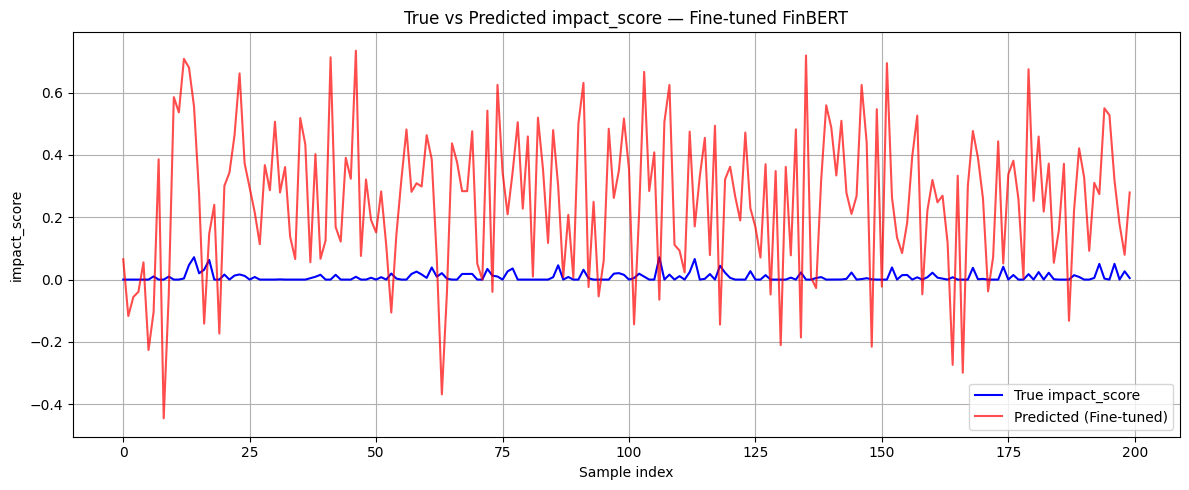

In [ ]:
# 📦 Импорт метрик
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt

# 🧠 Убеждаемся, что модель в режиме оценки
model.eval()

# 🔁 Сбор предсказаний
y_pred, y_true = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['target'].to(device)

        outputs = model(input_ids, attention_mask)

        y_pred.extend(outputs.cpu().numpy())
        y_true.extend(targets.cpu().numpy())

# 📊 Метрики
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred) * 100

print(f"📏 RMSE (Fine-tuned): {rmse:.5f}")
print(f"📉 MAPE (Fine-tuned): {mape:.2f}%")

# 📈 График сравнения
plt.figure(figsize=(12, 5))
plt.plot(y_true, label="True impact_score", color="blue")
plt.plot(y_pred, label="Predicted (Fine-tuned)", color="red", alpha=0.7)
plt.title("True vs Predicted impact_score — Fine-tuned FinBERT")
plt.xlabel("Sample index")
plt.ylabel("impact_score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Убедимся, что формат даты правильный
F_news['Date'] = pd.to_datetime(F_news['Date']).dt.tz_localize(None)
honda['Date'] = pd.to_datetime(honda['Date'])
intel['Date'] = pd.to_datetime(intel['Date'])
google['Date'] = pd.to_datetime(google['Date'])

# Показываем минимальные даты
print("📰 F_news starts from:", F_news['Date'].min().date())
print("🚗 Honda data starts from:", honda['Date'].min().date())
print("💻 Intel data starts from:", intel['Date'].min().date())
print("🌐 Google data starts from:", google['Date'].min().date())


📰 F_news starts from: 2009-08-22
🚗 Honda data starts from: 1980-03-17
💻 Intel data starts from: 1980-03-17
🌐 Google data starts from: 2020-01-02


переобучим тк mape большой и добавим макроэномические показатели(состояние рынка)

In [13]:
import yfinance as yf
import pandas as pd

# Загружаем с правильной даты
sp500 = yf.download("^GSPC", start="2009-08-22", end="2025-12-31")
sp500 = sp500[['Close']].reset_index()
sp500.columns = ['Date', 'SP500_Close']

# Вычисляем дневную доходность
sp500['SP500_Return'] = sp500['SP500_Close'].pct_change()
sp500['Date'] = pd.to_datetime(sp500['Date'])


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [15]:
import pandas as pd

# 1. Нормализуем и делаем обе колонки НАИВНЫМИ (без tz)
F_news['Date'] = (
    pd.to_datetime(F_news['Date'], utc=True)      # строка → UTC
      .dt.tz_localize(None)                       # убираем зону
      .dt.normalize()                             # оставляем 00:00:00
)

sp500['Date'] = (
    pd.to_datetime(sp500['Date'], errors='coerce')  # на всякий случай
      .dt.normalize()                               # 00:00:00
)

# 2. Заполняем пропуски в индексе S&P-500
sp500_filled = (
    sp500.set_index('Date')
         .asfreq('D', method='ffill')
         .reset_index()
)

# 3. Сливаем
news_for_merge = F_news.copy()        # если нужно сохранить оригинал
F_news_macro = news_for_merge.merge(
    sp500_filled[['Date', 'SP500_Return']],
    on='Date',
    how='left'
)

# 4. Проверяем
print(F_news_macro[['Date', 'Stock_symbol', 'Article_title', 'SP500_Return']].head())


        Date Stock_symbol                                      Article_title  \
0 2023-12-16         INTC  3 Overvalued Stocks That Could Plunge if the M...   
1 2023-12-16         INTC              IWD, MRK, BAC, INTC: ETF Inflow Alert   
2 2023-12-16         INTC                      Company News for Dec 20, 2023   
3 2023-12-16         INTC  Nvidia Stock Dominated 2023, but Investors Sho...   
4 2023-12-16         INTC                5 Top Stocks I'm Betting on in 2024   

   SP500_Return  
0     -0.000076  
1     -0.000076  
2     -0.000076  
3     -0.000076  
4     -0.000076  


In [16]:
tickers = ['GOOGL', 'INTC', 'HMC']
all_data = []

for ticker, price_df in [('GOOGL', google), ('INTC', intel), ('HMC', honda)]:
    news = F_news_macro[F_news_macro['Stock_symbol'] == ticker].copy()

    news['Date'] = pd.to_datetime(news['Date'])
    price_df['Date'] = pd.to_datetime(price_df['Date'])

    df = pd.merge(news, price_df[['Date', 'Close']], on='Date', how='inner')
    df['Close_next'] = df['Close'].shift(-1)
    df['impact_score'] = abs(df['Close_next'] - df['Close']) / df['Close']
    df = df.dropna(subset=['impact_score', 'SP500_Return'])

    all_data.append(df[['Article_title', 'impact_score', 'SP500_Return']])

df_all = pd.concat(all_data).reset_index(drop=True)


In [17]:
print(df.head())
print(df.columns)


  Stock_symbol                                      Article_title       Date  \
0          HMC  Shares of several automaker & auto component c... 2020-06-11   
1          HMC  Shares of several auto manufacturing & auto co... 2020-06-05   
2          HMC  Shares of several consumer discretionary compa... 2020-05-26   
3          HMC  Honda shares are trading lower after the compa... 2020-05-12   
4          HMC  Honda Motor Co Earlier Reported Q4 EPS $(0.160... 2020-05-12   

   sentiment_score  SP500_Return      Close  Close_next  impact_score  
0               -1     -0.058944  25.790001   27.980000      0.084917  
1                1      0.026212  27.980000   25.990000      0.071122  
2                1      0.012289  25.990000   22.709999      0.126202  
3               -1     -0.020500  22.709999   22.709999      0.000000  
4               -1     -0.020500  22.709999   23.969999      0.055482  
Index(['Stock_symbol', 'Article_title', 'Date', 'sentiment_score',
       'SP500_Return

In [18]:
df

,Stock_symbol,Article_title,Date,sentiment_score,SP500_Return,Close,Close_next,impact_score
0,HMC,Shares of several automaker & auto component c...,2020-06-11,-1,-0.058944,25.790001,27.980000,0.084917
1,HMC,Shares of several auto manufacturing & auto co...,2020-06-05,1,0.026212,27.980000,25.990000,0.071122
2,HMC,Shares of several consumer discretionary compa...,2020-05-26,1,0.012289,25.990000,22.709999,0.126202
3,HMC,Honda shares are trading lower after the compa...,2020-05-12,-1,-0.020500,22.709999,22.709999,0.000000
4,HMC,Honda Motor Co Earlier Reported Q4 EPS $(0.160...,2020-05-12,-1,-0.020500,22.709999,23.969999,0.055482
...,...,...,...,...,...,...,...,...
2144,HMC,NHTSA reports 9th death from faulty Takata airbag,2015-12-24,-1,-0.001599,32.400002,32.380001,0.000617
2145,HMC,The Most Overhyped Story Of 2015 - And 2016: D...,2015-12-23,0,0.012418,32.380001,32.169998,0.006486
2146,HMC,Robotic Exoskeletons Stepping Out Of Science F...,2015-12-22,0,0.008817,32.169998,32.169998,0.000000
2147,HMC,TrueCar forecasts big pop for U.S. car sales i...,2015-12-22,0,0.008817,32.169998,32.169998,0.000000


In [23]:

drive.mount('/content/drive')


# 3. Сохраняем
save_path = '/content/drive/My Drive/Colab Notebooks/main_df.csv'   # замените папку, если нужно
df.to_csv(save_path, index=False)

print(f'DataFrame сохранён по пути: {save_path}')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DataFrame сохранён по пути: /content/drive/My Drive/Colab Notebooks/main_df.csv


In [21]:
# A.  Добавляем тикер и дату в df_all, чтобы было к чему привязаться
df_all['Stock_symbol'] = df_all['Article_title'].map(
    dict(zip(F_news['Article_title'], F_news['Stock_symbol']))
)
df_all['Date'] = df_all['Article_title'].map(
    dict(zip(F_news['Article_title'], F_news['Date']))
)

# B.  Склеиваем impact_score → к F_news_macro
full_news = F_news_macro.merge(
    df_all[['Article_title', 'impact_score']],
    on='Article_title',
    how='left'
)


In [22]:
datasets = {}
tickers   = ['GOOGL', 'HMC', 'INTC']   # поправили опечатку 'HNC' → 'HMC'

for ticker in tickers:
    df = full_news[full_news['Stock_symbol'] == ticker].dropna(
        subset=['impact_score', 'SP500_Return']
    )

    X  = df['Article_title'].tolist()
    y  = df['impact_score'].tolist()
    s  = df['SP500_Return'].tolist()

    X_train, X_val, y_train, y_val, s_train, s_val = train_test_split(
        X, y, s, test_size=0.2, random_state=42
    )

    datasets[ticker] = {
        'X_train'     : X_train,
        'X_val'       : X_val,
        'y_train'     : y_train,
        'y_val'       : y_val,
        'sp500_train' : s_train,
        'sp500_val'   : s_val
    }


In [24]:
class NewsWithMacroDataset(Dataset):
    def __init__(self, texts, targets, sp500_values):
        self.texts = texts
        self.targets = targets
        self.sp500 = sp500_values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )
        return {
            'input_ids': enc['input_ids'].squeeze(),
            'attention_mask': enc['attention_mask'].squeeze(),
            'target': torch.tensor(self.targets[idx], dtype=torch.float32),
            'sp500': torch.tensor(self.sp500[idx], dtype=torch.float32)
        }


In [25]:
class FinBERTWithMacro(nn.Module):
    def __init__(self, bert):
        super().__init__()
        self.bert = bert
        self.regressor = nn.Linear(768 + 1, 1)  # +1 for SP500_Return

    def forward(self, input_ids, attention_mask, sp500):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls = outputs.last_hidden_state[:, 0]  # [CLS]
        combined = torch.cat((cls, sp500.unsqueeze(1)), dim=1)
        return self.regressor(combined).squeeze()


In [26]:

# 📌 Разбивка данных
X_train, X_val, y_train, y_val, sp500_train, sp500_val = train_test_split(
    df_all['Article_title'].tolist(),
    df_all['impact_score'].tolist(),
    df_all['SP500_Return'].tolist(),
    test_size=0.2,
    random_state=42
)

In [27]:
# 📌 Разбивка данных
X_train, X_val, y_train, y_val, sp500_train, sp500_val = train_test_split(
    df_all['Article_title'].tolist(),
    df_all['impact_score'].tolist(),
    df_all['SP500_Return'].tolist(),
    test_size=0.2,
    random_state=42
)

# 📦 Dataset
train_dataset = NewsWithMacroDataset(X_train, y_train, sp500_train)
val_dataset = NewsWithMacroDataset(X_val, y_val, sp500_val)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import os


# 📥 Загружаем токенизатор и BERT
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
bert = AutoModel.from_pretrained("ProsusAI/finbert")

# 🧠 Модель
model = FinBERTWithMacro(bert).to(device)

# 🧊 (по желанию) разморозим BERT
for param in model.bert.parameters():
    param.requires_grad = True

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.MSELoss()

# 🏋️‍♂️ Обучение с индикатором
for epoch in range(5):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)

    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sp500 = batch['sp500'].to(device)
        targets = batch['target'].to(device)

        outputs = model(input_ids, attention_mask, sp500)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    print(f"✅ Epoch {epoch+1} — Average MSE: {avg_loss:.5f}")

# 💾 Сохраняем модель
torch.save(model.state_dict(), "finbert_with_macro.pt")

# 📤 Копируем в Google Диск
!cp finbert_with_macro.pt "/content/drive/MyDrive/Colab Notebooks/finbert_with_macro.pt"

print("✅ Model saved and uploaded to Google Drive!")


KeyboardInterrupt: 

In [ ]:
from transformers import AutoModel

bert = AutoModel.from_pretrained("ProsusAI/finbert")


In [32]:
# Скопировать файл обратно из Диска в текущую директорию
!cp "/content/drive/MyDrive/Colab Notebooks/finbert_with_macro.pt" ./


In [33]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bert = AutoModel.from_pretrained("ProsusAI/finbert")
model = FinBERTWithMacro(bert).to(device)

model.load_state_dict(torch.load("finbert_with_macro.pt", map_location=device))
model.eval()


FinBERTWithMacro(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [29]:
print(type(sp500_val), len(sp500_val))
print(sp500_val[:5])  # первые 5 значений


<class 'list'> 561
[-0.010995693172566212, -0.0010052630048559275, 0.002943716919978634, -0.001082200145408052, 0.00047134296924533636]


In [30]:
# Проверка вывода модели
model.eval()

# Берём одну партию
batch = next(iter(val_loader))

# Извлекаем входы
input_ids = batch['input_ids'].to(device)
attention_mask = batch['attention_mask'].to(device)
sp500 = batch['sp500'].to(device)

# Прогон через модель
with torch.no_grad():
    outputs = model(input_ids, attention_mask, sp500)

print("✅ Output shape:", outputs.shape)
print("📊 Output values (first 5):", outputs[:5].cpu().numpy().tolist())


✅ Output shape: torch.Size([4])
📊 Output values (first 5): [-0.18591764569282532, 0.3021332323551178, 0.20360681414604187, 0.25625473260879517]


✅ RMSE (with SP500): 0.01682
✅ MAPE (with SP500): 3194994306372647.00%


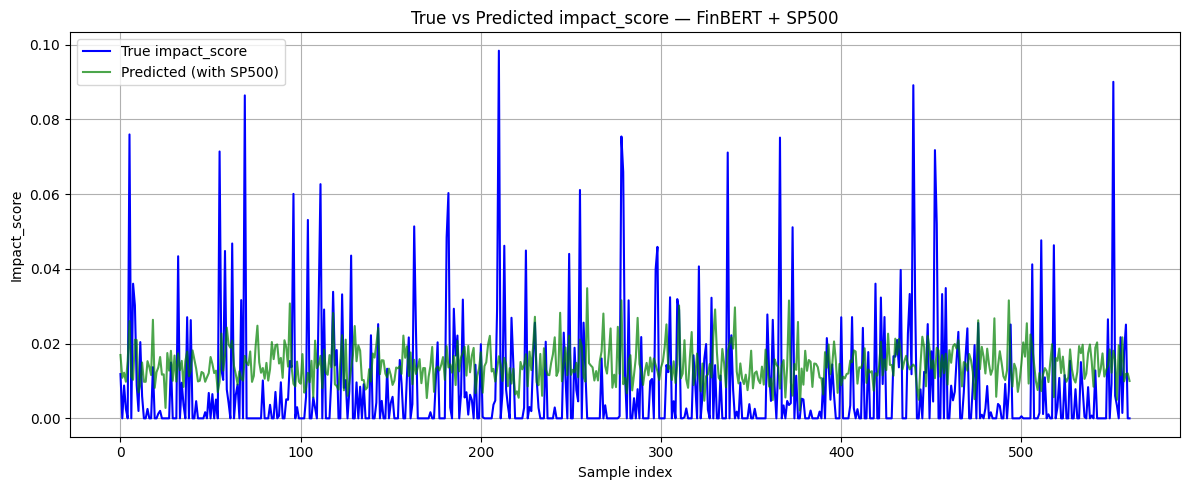

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np

model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sp500 = batch['sp500'].to(device)
        targets = batch['target'].to(device)

        outputs = model(input_ids, attention_mask, sp500)

        # Гарантируем плоские списки (важно!)
        y_pred.extend(outputs.view(-1).cpu().numpy().tolist())
        y_true.extend(targets.view(-1).cpu().numpy().tolist())

# 🧮 Метрики
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred) * 100

print(f"✅ RMSE (with SP500): {rmse:.5f}")
print(f"✅ MAPE (with SP500): {mape:.2f}%")

# 📊 График
plt.figure(figsize=(12, 5))
plt.plot(y_true, label="True impact_score", color="blue")
plt.plot(y_pred, label="Predicted (with SP500)", color="green", alpha=0.7)
plt.title("True vs Predicted impact_score — FinBERT + SP500")
plt.xlabel("Sample index")
plt.ylabel("Impact_score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm
import os

# Подключаем Google Диск
from google.colab import drive
drive.mount('/content/drive')

# Папка на Google Диске для сохранения
save_dir = "/content/drive/MyDrive/Colab Notebooks"

# Компании
tickers = ["GOOGL", "HMC", "INTC"]

# Загружаем BERT и токенизатор
bert = AutoModel.from_pretrained("ProsusAI/finbert")
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

# Модель
class FinBERTRegressor(torch.nn.Module):
    def __init__(self, bert):
        super().__init__()
        self.bert = bert
        self.regressor = torch.nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0]
        return self.regressor(cls_output).squeeze()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Цикл по каждой компании
for ticker in tickers:
    print(f"\n🚀 Training model for {ticker}")

    # 🔁 Вставь здесь подготовку данных:
    # X_train, y_train = ...  # список текстов и числовых значений
    # dataset = NewsWithMacroDataset(X_train, y_train, [0]*len(y_train))  # dummy SP500 if unused
    # loader = DataLoader(dataset, batch_size=16, shuffle=True)

    continue  # Убери после вставки своих данных

    model = FinBERTRegressor(bert).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
    loss_fn = torch.nn.MSELoss()

    for epoch in range(3):
        model.train()
        total_loss = 0
        loop = tqdm(loader, desc=f"[{ticker}] Epoch {epoch+1}", leave=False)

        for batch in loop:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['target'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        print(f"[{ticker}] Epoch {epoch+1} avg loss: {total_loss / len(loader):.4f}")

    # 💾 Сохраняем модель с названием по компании
    model_name = f"finbert_with_macro_{ticker.lower()}.pt"
    torch.save(model.state_dict(), model_name)

    # 📤 Копируем в Google Диск
    !cp $model_name "$save_dir/$model_name"

    print(f"✅ Model for {ticker} saved as {model_name} to Google Drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

🚀 Training model for GOOGL

🚀 Training model for HMC

🚀 Training model for INTC


In [37]:
print(F_news_macro.columns)


Index(['Stock_symbol', 'Article_title', 'Date', 'sentiment_score',
       'SP500_Return'],
      dtype='object')


In [38]:
print(df_all.columns)

Index(['Article_title', 'impact_score', 'SP500_Return', 'Stock_symbol',
       'Date'],
      dtype='object')


In [ ]:
# Копируем значения из df_all по Article_title
F_news_macro = F_news_macro.merge(df_all, on='Article_title', how='left')

# Проверим наличие
print(F_news_macro.columns)


Index(['Stock_symbol', 'Article_title', 'Date', 'sentiment_score',
       'SP500_Return_x', 'impact_score', 'SP500_Return_y'],
      dtype='object')


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1754 entries, 8682 to 11603
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Stock_symbol     1754 non-null   object        
 1   Article_title    1754 non-null   object        
 2   Date             1754 non-null   datetime64[ns]
 3   sentiment_score  1754 non-null   int64         
 4   SP500_Return     1754 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 82.2+ KB


In [39]:
# A.  у df_all уже есть Article_title  +  impact_score
#     осталось добавить туда Date и Stock_symbol, чтобы было по чему соединять
df_all = df_all.merge(
    F_news[['Article_title', 'Date', 'Stock_symbol']],
    on='Article_title',
    how='left'
)

# B.  соединяем новости + макро + impact_score
full_news = (
    F_news_macro                # Date • Stock_symbol • Article_title • SP500_Return
      .merge(                   # + impact_score
          df_all[['Article_title', 'impact_score']],
          on='Article_title',
          how='left'
      )
      .dropna(subset=['impact_score', 'SP500_Return'])   # чтобы не было пропусков
      .reset_index(drop=True)
)

print(full_news.columns)
# ➜  Index(['Date','Stock_symbol','Article_title','SP500_Return','impact_score'], ...)
print(len(full_news))           # убедитесь, что строк теперь > 15


Index(['Stock_symbol', 'Article_title', 'Date', 'sentiment_score',
       'SP500_Return', 'impact_score'],
      dtype='object')
4175


In [40]:
from sklearn.model_selection import train_test_split

datasets = {}
tickers   = ['GOOGL', 'HMC', 'INTC']   # поправили опечатку

for ticker in tickers:
    df = full_news[full_news['Stock_symbol'] == ticker]

    X = df['Article_title'].tolist()
    y = df['impact_score'].tolist()
    s = df['SP500_Return'].tolist()

    X_train, X_val, y_train, y_val, s_train, s_val = train_test_split(
        X, y, s, test_size=0.2, random_state=42
    )

    datasets[ticker] = {
        'X_train'     : X_train,
        'X_val'       : X_val,
        'y_train'     : y_train,
        'y_val'       : y_val,
        'sp500_train' : s_train,
        'sp500_val'   : s_val
    }

print({k: len(v['X_train']) for k,v in datasets.items()})


{'GOOGL': 700, 'HMC': 2620, 'INTC': 19}


In [48]:
tickers = ['GOOGL', 'HMC', 'INTC']
datasets = {}

for ticker in tickers:
    df = full_news[full_news['Stock_symbol'] == ticker]   # ← было f_news_macro [...]

    X     = df['Article_title'].tolist()
    y     = df['impact_score'].tolist()
    sp500 = df['SP500_Return'].tolist()

    X_tr, X_val, y_tr, y_val, s_tr, s_val = train_test_split(
        X, y, sp500, test_size=0.2, random_state=42
    )

    datasets[ticker] = {
        'X_train'    : X_tr,
        'X_val'      : X_val,
        'y_train'    : y_tr,
        'y_val'      : y_val,
        'sp500_train': s_tr,
        'sp500_val'  : s_val
    }


In [49]:


    # Динамически сохраняем в переменные
    globals()[f'X_train_{ticker.lower()}'] = X_train
    globals()[f'X_val_{ticker.lower()}'] = X_val
    globals()[f'y_train_{ticker.lower()}'] = y_train
    globals()[f'y_val_{ticker.lower()}'] = y_val
    globals()[f'sp500_train_{ticker.lower()}'] = sp500_train
    globals()[f'sp500_val_{ticker.lower()}'] = sp500_val


In [58]:
class NewsWithMacroDataset(Dataset):
    def __init__(self, texts, targets, sp500):
        self.texts   = texts
        self.targets = targets
        self.sp500   = sp500

    def __getitem__(self, idx):
        enc = tokenizer(self.texts[idx],
                        padding='max_length',
                        truncation=True,
                        max_length=128,
                        return_tensors='pt')

        return {
            'input_ids'     : enc['input_ids'].squeeze(),
            'attention_mask': enc['attention_mask'].squeeze(),
            # 👉  делаем тензор формы (1,) — обращаем внимание на extra []
            'sp500'         : torch.tensor([self.sp500[idx]], dtype=torch.float32),
            'target'        : torch.tensor(self.targets[idx], dtype=torch.float32)
        }

    def __len__(self):
        return len(self.texts)


In [61]:
class FinBERTWithMacro(nn.Module):
    def __init__(self, bert):
        super().__init__()
        self.bert = bert
        self.regressor = nn.Linear(768 + 1, 1)   # 768 CLS + 1 макро-признак

    def forward(self, input_ids, attention_mask, sp500):
        out = self.bert(input_ids=input_ids,
                        attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0]          # (B, 768)

        # ---- ключевая строка ----
        if sp500.dim() == 1:                       # (B,) → (B,1)
            sp500 = sp500.unsqueeze(1)             # но если уже (B,1) — ничего не делаем
        # -------------------------

        combined = torch.cat((cls, sp500), dim=1)  # (B, 769)
        return self.regressor(combined).squeeze()


In [65]:
val_dataset = NewsWithMacroDataset(X_val_googl, y_val_googl, sp500_val_googl)
val_loader  = DataLoader(val_dataset, batch_size=4)

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in val_loader:
        ids  = batch['input_ids'     ].to(device)          # (B, 128)
        msk  = batch['attention_mask'].to(device)          # (B, 128)
        s500 = batch['sp500'         ].to(device).float()  # (B, 1)  ─ уже 2-D!

        # ──> model.forward ожидает (ids, msk, sp500) — ничего добавлять не надо
        out  = model(ids, msk, s500)                       # (B,)  или  (B,1)

        # аккуратно собираем в списки
        y_pred.extend(out.squeeze().cpu().tolist())
        y_true.extend(batch['target'].cpu().tolist())


RuntimeError: Tensors must have same number of dimensions: got 2 and 3

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm

# Настройки
EPOCHS = 10
BATCH_SIZE = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Модель FinBERT
bert = AutoModel.from_pretrained("ProsusAI/finbert")
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

class FinBERTWithMacro(nn.Module):
    def __init__(self, bert):
        super().__init__()
        self.bert = bert
        self.regressor = nn.Linear(768 + 1, 1)

    def forward(self, input_ids, attention_mask, sp500):
        cls = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0]
        combined = torch.cat((cls, sp500.unsqueeze(1)), dim=1)
        return self.regressor(combined).squeeze()

class NewsWithMacroDataset(Dataset):
    def __init__(self, texts, targets, sp500):
        self.texts = texts
        self.targets = targets
        self.sp500 = sp500

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded = tokenizer(self.texts[idx], padding='max_length', truncation=True, max_length=128, return_tensors='pt')
        return {
            'input_ids': encoded['input_ids'].squeeze(),
            'attention_mask': encoded['attention_mask'].squeeze(),
            'target': torch.tensor(self.targets[idx], dtype=torch.float32),
            'sp500': torch.tensor(self.sp500[idx], dtype=torch.float32)
        }

# Обучающие датасеты по тикерам (у тебя должны быть эти переменные заранее определены)
datasets = {
    'GOOGL': (X_train_googl, y_train_googl, sp500_train_googl),
    'HMC': (X_train_hmc, y_train_hmc, sp500_train_hmc),
    'INTC': (X_train_intc, y_train_intc, sp500_train_intc)
}

save_dir = "/content/drive/MyDrive/Colab Notebooks"

for ticker, (texts, targets, sp500_values) in datasets.items():
    print(f"🚀 Начинаем обучение модели для {ticker}")

    model = FinBERTWithMacro(bert).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
    loss_fn = nn.MSELoss()

    dataset = NewsWithMacroDataset(texts, targets, sp500_values)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0
        loop = tqdm(loader, desc=f"{ticker} Epoch {epoch+1}")
        for batch in loop:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['target'].to(device)
            sp500 = batch['sp500'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, sp500)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        print(f"✅ Epoch {epoch+1} for {ticker} — avg loss: {total_loss / len(loader):.4f}")

    # Сохраняем модель
    model_path = f"finbert_with_macro_{ticker.lower()}.pt"
    torch.save(model.state_dict(), model_path)
    !cp {model_path} "{save_dir}/{model_path}"
    print(f"💾 Модель {ticker} сохранена на Google Диск под именем {model_path}")


🚀 Начинаем обучение модели для GOOGL


GOOGL Epoch 1:  99%|█████████▉| 88/89 [38:18<00:26, 26.46s/it, loss=nan]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
GOOGL Epoch 1: 100%|██████████| 89/89 [38:20<00:00, 25.85s/it, loss=nan]


✅ Epoch 1 for GOOGL — avg loss: nan


GOOGL Epoch 2: 100%|██████████| 89/89 [38:03<00:00, 25.66s/it, loss=nan]


✅ Epoch 2 for GOOGL — avg loss: nan


GOOGL Epoch 3: 100%|██████████| 89/89 [38:03<00:00, 25.65s/it, loss=nan]


✅ Epoch 3 for GOOGL — avg loss: nan


GOOGL Epoch 4: 100%|██████████| 89/89 [37:59<00:00, 25.61s/it, loss=nan]


✅ Epoch 4 for GOOGL — avg loss: nan


GOOGL Epoch 5: 100%|██████████| 89/89 [37:55<00:00, 25.57s/it, loss=nan]


✅ Epoch 5 for GOOGL — avg loss: nan


GOOGL Epoch 6: 100%|██████████| 89/89 [38:05<00:00, 25.68s/it, loss=nan]


✅ Epoch 6 for GOOGL — avg loss: nan


GOOGL Epoch 7: 100%|██████████| 89/89 [38:09<00:00, 25.73s/it, loss=nan]


✅ Epoch 7 for GOOGL — avg loss: nan


GOOGL Epoch 8: 100%|██████████| 89/89 [38:13<00:00, 25.77s/it, loss=nan]


✅ Epoch 8 for GOOGL — avg loss: nan


GOOGL Epoch 9: 100%|██████████| 89/89 [38:03<00:00, 25.66s/it, loss=nan]


✅ Epoch 9 for GOOGL — avg loss: nan


GOOGL Epoch 10: 100%|██████████| 89/89 [38:01<00:00, 25.63s/it, loss=nan]


✅ Epoch 10 for GOOGL — avg loss: nan
💾 Модель GOOGL сохранена на Google Диск под именем finbert_with_macro_googl.pt
🚀 Начинаем обучение модели для HMC


HMC Epoch 1: 100%|██████████| 117/117 [50:32<00:00, 25.92s/it, loss=nan]


✅ Epoch 1 for HMC — avg loss: nan


HMC Epoch 2: 100%|██████████| 117/117 [50:18<00:00, 25.80s/it, loss=nan]


✅ Epoch 2 for HMC — avg loss: nan


HMC Epoch 3: 100%|██████████| 117/117 [50:33<00:00, 25.92s/it, loss=nan]


✅ Epoch 3 for HMC — avg loss: nan


HMC Epoch 4:   6%|▌         | 7/117 [03:02<49:10, 26.82s/it, loss=nan]

In [ ]:
class NewsWithMacroDataset(Dataset):
    ...
    def __getitem__(self, idx):
        enc = tokenizer(self.texts[idx], padding='max_length',
                        truncation=True, max_length=128, return_tensors='pt')
        return {
            'input_ids'     : enc['input_ids'].squeeze(),
            'attention_mask': enc['attention_mask'].squeeze(),
            # ⬇️  БЕЗ квадратных скобок  — сразу скаляр
            'sp500'         : torch.tensor(self.sp500[idx], dtype=torch.float32),
            'target'        : torch.tensor(self.targets[idx], dtype=torch.float32)
        }


GOOGL  |  RMSE: 0.01560   MAPE: 5870685386223005.00%


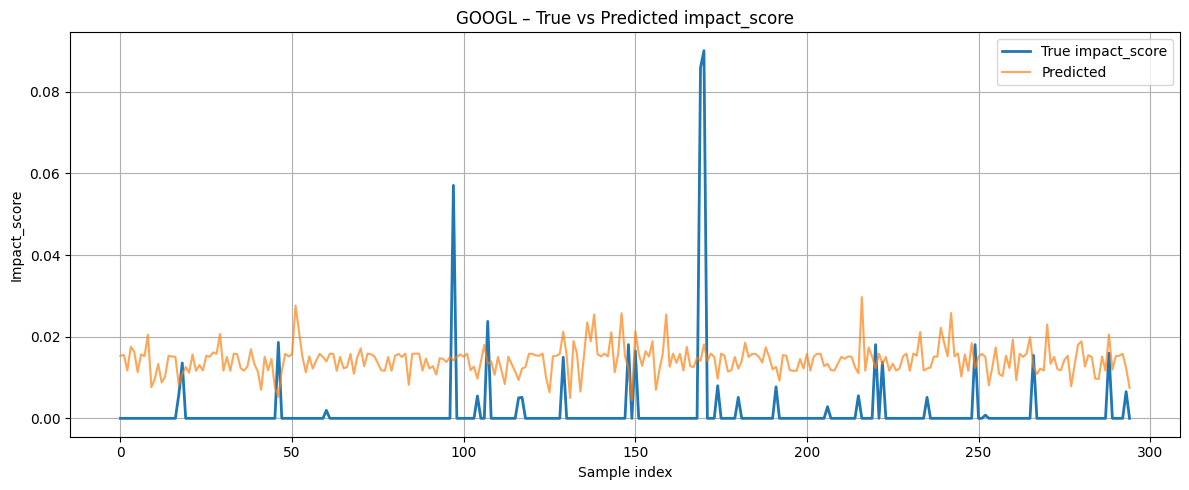

In [67]:
# === Проверка модели finbert_with_macro на валидационном наборе GOOGL =========
import torch, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from torch.utils.data import Dataset, DataLoader

# ----- 1. Датасет с макропризнаком (форма sp500 → (1,))
class NewsWithMacroDataset(Dataset):
    def __init__(self, texts, targets, sp500):
        self.texts, self.targets, self.sp500 = texts, targets, sp500
    def __len__(self):  return len(self.texts)
    def __getitem__(self, idx):
        enc = tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True, max_length=128,
            return_tensors='pt'
        )
        return {
            'input_ids'     : enc['input_ids'].squeeze(),
            'attention_mask': enc['attention_mask'].squeeze(),
            'sp500'         : torch.tensor([self.sp500[idx]], dtype=torch.float32),
            'target'        : torch.tensor(self.targets[idx],   dtype=torch.float32)
        }

# ----- 2. Вал-набор GOOGL ----------------------------------------------------
g = datasets['GOOGL']                                   # X_val, y_val, sp500_val
val_ds = NewsWithMacroDataset(g['X_val'], g['y_val'], g['sp500_val'])
val_ld = DataLoader(val_ds, batch_size=8)

# ----- 3. Инференс -----------------------------------------------------------
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in val_ld:
        ids  = batch['input_ids'     ].to(device)
        msk  = batch['attention_mask'].to(device)
        s500 = batch['sp500'         ].to(device)

        out = model(ids, msk, s500)                 # (B,)
        y_pred.extend(out.cpu().tolist())
        y_true.extend(batch['target'].tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# ----- 4. Метрики ------------------------------------------------------------
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)                                   # ↔ squared=False
mape = mean_absolute_percentage_error(y_true, y_pred) * 100

print(f"GOOGL  |  RMSE: {rmse:.5f}   MAPE: {mape:.2f}%")

# ----- 5. График -------------------------------------------------------------
plt.figure(figsize=(12,5))
plt.plot(y_true, label='True impact_score', lw=2)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.title('GOOGL – True vs Predicted impact_score')
plt.xlabel('Sample index'); plt.ylabel('Impact_score')
plt.legend(); plt.grid(); plt.tight_layout(); plt.show()


гипотпеза: обучить чисто гуглу еще хуже